###GAN - Generative Adversarial Network### 

**GAN** là phương thức xây dựng các mô hình sinh (generative model) được xây dựng từ các mô hình nơron thần kinh (Neural Network), ví dụ là mạng tích chập (CNN).

Các mô hình sinh thường là các mô hình thuộc học không giám sát (unsupervied learning) liên quan đến việc khám phá, tìm hiểu các quy luật của dữ liệu đầu vào, mà mô hình có thể học và tạo ra các dữ liệu mới được rút ra kinh nghiệm từ dữ liệu gốc.

GAN là là một cách thức rất thông minh trong việc xây dựng các mô hình sinh, xây dựng bằng cách đóng gói vấn đề với hai mô hình con, một mô hình tạo (generator model) nhằm mục đích xây dựng các ví dụ mới, mô hình còn lại là mô hình phân biệt (discriminator model) có nhiệm vụ phân loại các dữ liệu, phân biệt xem nó là thật (real - data sẵn) hay giả (fake - được tạo ra từ G model). Hai mô hình được huấn luyện cùng nhau trong một trò chơi có tổng bằng không (zero-sum game - Tức tổng kết quả đạt được của hai model luôn bằng không, cách nói trong kinh tế là lợi ích đạt được của người thắng bằng tổng lỗ của người thua), cho đến khi mô hình phân biệt $< \frac{1}{2}$ mô hình tạo, tức mô hình tạo càng cho ra các kết quả tốt hơn. 

<image src='https://i2.wp.com/nttuan8.com/wp-content/uploads/2019/11/1-1.png?fit=1024%2C680&ssl=1'></image>


Đê hiểu rõ hơn chúng ta sẽ lấy ví dụ ở hình ảnh trên, Generator sẽ là tên làm tiền giả và Discriminator sẽ là các bộ cảnh sát có nhiệm vụ phân biệt tiền thật và tiền giả do Generator làm ra. Mục tiêu cuối cùng là Generator sẽ tạo ra được tiền giả mà Discriminator không thể phân biệt được để mà tuồn ra thị trường.

Trong quá trình huấn luyện, Discriminator sẽ phân biệt tiền giả và tiền thật, nếu là tiền giả thì sẽ sẽ thông báo cho Generator là tiền nó còn kém lắm, chưa đủ để đánh lừa. Dần dần thì tiền giả sẽ càng giống tiền thật hơn.

[Cheatsheet GAN](https://drive.google.com/file/d/1Gm4hNSXY03DrYDU4rh0NRlDcXo20a3pL/view?usp=sharing)



### GAN 

Chúng ta sẽ tìm hiểu và xây dựng mô hình GAN với bộ dữ liệu Mnist

In [2]:
! nvidia-smi

Fri Sep  4 22:52:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Kiến trúc model 

<table><tr>
<td> <img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Discriminator-Model-in-the-MNIST-GAN.png" alt="Drawing" style="width: 500px;"/> 
<p>Discriminator Model</p></td>
<td> <img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Generator-Model-in-the-MNIST-GAN.png" alt="Drawing" style="width: 500px;"/> <p>Generator Model</p></td>
</tr></table>

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dense, Input, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.mnist import load_data
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from keras.optimizers import Adam
from tqdm import tqdm

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = load_data()

# shape
print('Train: ', x_train.shape)
print('Test: ', x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train:  (60000, 28, 28)
Test:  (10000, 28, 28)


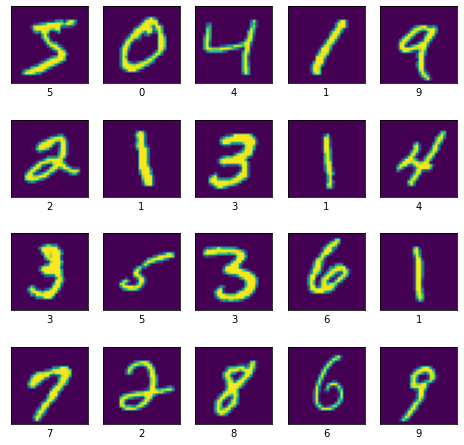

In [5]:
# Hiển thị 20 hình ảnh đầu tiên
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(20):
  fig.add_subplot(4, 5, i + 1)
  plt.xlabel(y_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i])
plt.show()

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = Conv2D(filters=64, strides=2, kernel_size=3,
                              padding='same')
        self.conv2 = Conv2D(filters=64, strides=2, kernel_size=3,
                             padding='same')
        self.leaky_relu1 = LeakyReLU(alpha=0.2)
        self.leaky_relu2 = LeakyReLU(alpha=0.2)
        self.drop1 = Dropout(rate=0.4)
        self.drop2 = Dropout(rate=0.4)
        self.flatten = Flatten()
        self.dense = Dense(units=1, activation='sigmoid')

    def call(self, input):
        x = self.conv1(input)
        x = self.leaky_relu1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.drop2(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x

    def summary(self):
        x = Input(shape=(28, 28, 1))
        return Model(inputs=[x], outputs=self.call(x))


model = Discriminator()
model_func = model.summary()
model_func.summary()

Mô hình Generator có nhiệm vụ là xây dựng các ảnh giả (fake), nó thực hiện bằng cách lấy dữ liệu đầu vào là một điểm trong latent spaces và đầu ra là một ảnh xám (28x28).

Latent Space là một không giác vector được xác định tùy ý, các giá trị được phân phối theo Gaussian, ví dụ là kích thước mỗi vector sẽ là 100. Bằng cách xây dựng các điểm này một cách ngẫu nhiên sẽ là đầu vào cho Generator để huấn luyện. Dựa vào các điểm này mô hình sẽ sinh ra các ảnh giả một cách hợp lý.

Việc cập nhật của mô hình Generator phụ thuộc vào kết quả phân loại của mô hình Discrimator. Khi mô hình Discrimator có độ chính xác cao thì mô hình Generator sẽ cập nhật nhiều hơn và ngược lại. Điều này thể hiện mối quan hệ giữa D và G thông qua lý thuyết zero-sum.  


In [23]:
class Generator(Model):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.dense = Dense(128 * 7 * 7, input_dim=latent_dim)
        self.leaky_relu1 = LeakyReLU(alpha=0.2)
        self.reshape = Reshape((7, 7, 128))
        self.conv2d_transpose1 = Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')
        self.leaky_relu2 = LeakyReLU(alpha=0.2)
        self.conv2d_transpose2 = Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')
        self.leaky_relu3 = LeakyReLU(alpha=0.2)
        self.conv = Conv2D(filters=1, kernel_size=7, activation='sigmoid', padding='same')


    def call(self, x):
        x = self.dense(x)
        x = self.leaky_relu1(x)
        x = self.reshape(x)
        x = self.conv2d_transpose1(x)
        x = self.leaky_relu2(x)
        x = self.conv2d_transpose2(x)
        x = self.leaky_relu3(x)
        out = self.conv(x)
        return out

    def summary(self):
        x = Input(shape=(128 * 7 * 7))
        return Model(inputs=[x], outputs=self.call(x))


model = Generator(latent_dim=100)
model_func = model.summary()
model_func.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 6272)]            0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              39344256  
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 128)      

Mô hình GAN sẽ là một ngăn xếp xếp chồng hai mô hình G và D nhằm đầu ra của G sẽ là đầu vào của D để phân loại và đầu ra của mô hình này sẽ được sử dụng để cập nhật cho G. 

Khi huấn luyện G thông qua GAN thì chúng ta mong muốn rằng mô hình D sẽ phân biệt nhầm các ảnh giả từ G sẽ là ảnh thật. Do đó, khi huấn luyện mô hình G trên GAN, chúng ta sẽ gắn nhãn các dữ liệu được tạo là 1. Lý do là khi huấn luyện mô hình D, nó sẽ phân loại các dữ liệu là fake từ G hoặc xác suất ảnh thật sẽ thấp (0.3 - 0.5). Quá trình lan truyền ngược khi cập nhật trọng số sẽ biết đây là một lỗi lớn và sẽ cập nhật trọng số của mô hình (Generator), giúp tăng cường huấn luyện mô hình G tốt hơn.

In [38]:
class GAN(Model):
    def __init__(self, G_model, D_model):
        super(GAN, self).__init__()
        self.G_model = G_model
        self.D_model = D_model
        self.D_model.trainable = False

    def call(self, x):
        x = self.G_model(x)
        out = self.D_model(x)
        return out

    def summary(self):
        x = Input(shape=(7 * 7 * 128))
        return Model(inputs=[x], outputs=self.call(x))


In [10]:
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32') # int -> float
	X = X / 255.0
	return X

Dữ liệu huấn luyện cho Discrimator là tập dữ liệu bao gồm ảnh thật và cả ảnh giả để Discrimator phân biệt. Do đó chúng ta cần xây dựng hai hàm chuẩn bị dữ liệu để huấn luyện, một hàm chọn các ảnh thật, chúng sẽ được lựa chọn ngẫu nhiên trong bộ mnist. Một hàm sẽ tạo ra các ảnh giả từ mô hình Generator. 

In [11]:
def generate_real_samples(dataset, n_samples):
	# chọn ngẫu nhiên n ảnh thật
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	# ảnh thật có nhãn là 1 - real
	y = ones((n_samples, 1))
	return X, y

In [19]:
def generate_latent_points(latent_dim, n_samples):
  # tạo các điểm từ latent space
	x_input = randn(latent_dim * n_samples)
  # reshape (n, 100)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [20]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# tạo ra các điểm từ latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	# các ảnh fake sẽ được đánh nhãn là 0
	y = zeros((n_samples, 1))
	return X, y

Đánh giá mô hình chúng ta sẽ xem kết quả của mô hình sau mỗi lần huấn luyện. Khi lưu mô hình, chúng ta cố gắng lưu khi loss là nhỏ nhất.

In [29]:
def visualize_fake_data(data):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(20):
    fig.add_subplot(4, 5, i + 1)
    plt.imshow(data[i], cmap='gray')
  plt.show()

In [24]:
g_model = Generator(latent_dim=100)
x_fake, y_fake = generate_fake_samples(g_model, latent_dim=100, n_samples=100)

In [33]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# dữ liệu thực
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# đánh giá độc chính xác thông qua dữ liệu thực 
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# dữ liệu giả 
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# đánh giá thông qua dữ liệu giả
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	visualize_fake_data(np.asarray(x_fake).squeeze())
	

### Xây dựng quá trình huấn luyện.

Dữ liệu huấn luyện sẽ có 60 nghìn ảnh, với batch_size=60 thì chúng ta sẽ có 234 lần huấn luyện trên 1 epoch. Dữ liệu huấn luyện cho mô hình D sẽ là dữ liệu giả và thật (50-50)

In [47]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		g_losses = 0
		d_losses = 0
		for j in tqdm(range(bat_per_epo)):
			# chuẩn bị dữ liệu thật 
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# chuẩn bị dữ liệu giả
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# tạo dữ liệu cho mô hình d
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# cập nhật trọng số cho mô hình d
			d_loss, _ = d_model.train_on_batch(X, y)
			# chuẩn bị các điểm từ latent space cho generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# tạo nhãn 1 cho các dữ liệu giả
			y_gan = ones((n_batch, 1))
			# cập nhật trọng số cho mô hình g thông qua mô hình GAN
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			d_losses += d_loss
			g_losses += g_loss
			# loss
		if (i+1) % 2 == 0:
			print('Epoch {}: d = {} - g = {}'.format(i, d_losses/bat_per_epo, g_losses/bat_per_epo))
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

100%|██████████| 234/234 [00:25<00:00,  9.10it/s]


Epoch 1: d = 0.6920685821618789 - g = 0.7381019143976717
>Accuracy real: 43%, fake: 88%


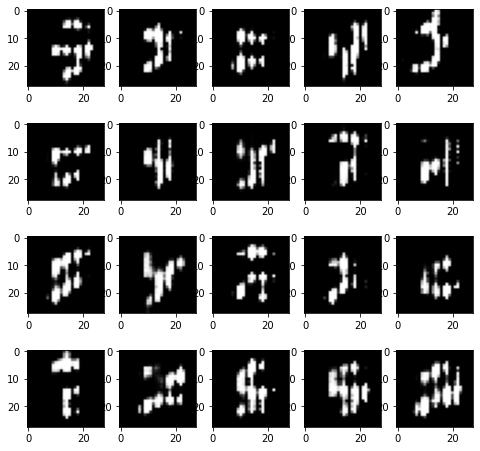

  2%|▏         | 4/234 [00:00<00:29,  7.91it/s]


KeyboardInterrupt: ignored

In [48]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = Discriminator()
opt = Adam(lr=0.0002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# create the generator
g_model = Generator(latent_dim)
# create the gan
gan_model = GAN(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)